In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [5]:
image_size = (140, 140)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 4091 files belonging to 2 classes.
Using 3273 files for training.
Found 4091 files belonging to 2 classes.
Using 818 files for validation.


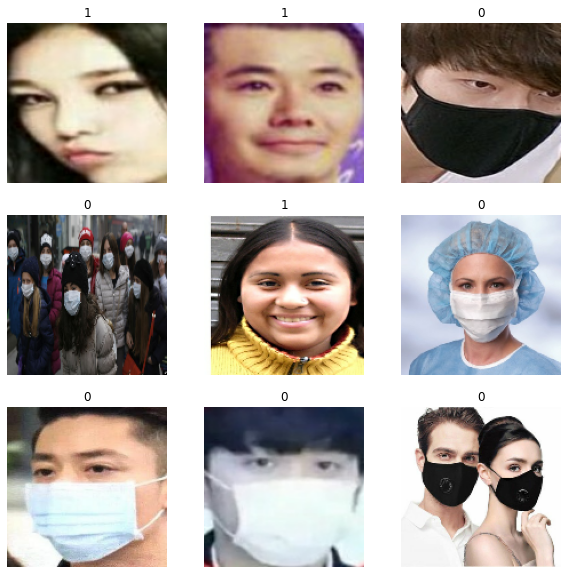

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

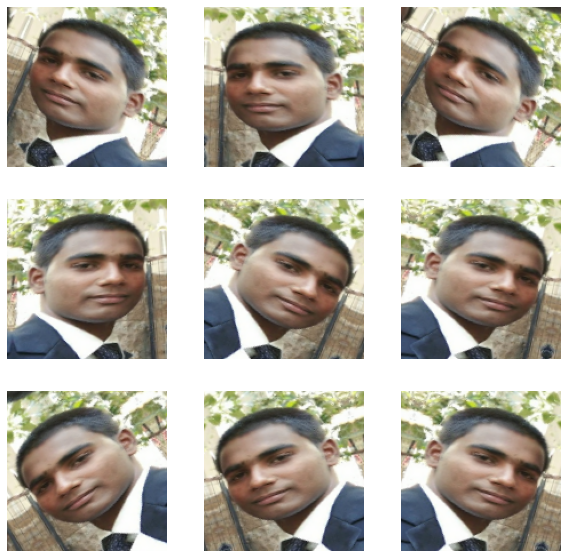

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [11]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/50
103/103 [==============================] - 36s 243ms/step - loss: 0.3580 - accuracy: 0.8524 - val_loss: 0.7012 - val_accuracy: 0.5183


C:\Users\olsen\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
103/103 [==============================] - 21s 205ms/step - loss: 0.2347 - accuracy: 0.9135 - val_loss: 0.7074 - val_accuracy: 0.5183
Epoch 3/50
103/103 [==============================] - 22s 208ms/step - loss: 0.1956 - accuracy: 0.9251 - val_loss: 0.6196 - val_accuracy: 0.7677
Epoch 4/50
103/103 [==============================] - 22s 208ms/step - loss: 0.1570 - accuracy: 0.9404 - val_loss: 0.3843 - val_accuracy: 0.8716
Epoch 5/50
103/103 [==============================] - 22s 208ms/step - loss: 0.1506 - accuracy: 0.9478 - val_loss: 0.3304 - val_accuracy: 0.8276
Epoch 6/50
103/103 [==============================] - 22s 210ms/step - loss: 0.1347 - accuracy: 0.9502 - val_loss: 0.1133 - val_accuracy: 0.9597
Epoch 7/50
103/103 [==============================] - 21s 200ms/step - loss: 0.1095 - accuracy: 0.9588 - val_loss: 0.0661 - val_accuracy: 0.9780
Epoch 8/50
103/103 [==============================] - 20s 194ms/step - loss: 0.1042 - accuracy: 0.9594 - val_loss: 0.1026 - val_ac

(-0.5, 139.5, 139.5, -0.5)

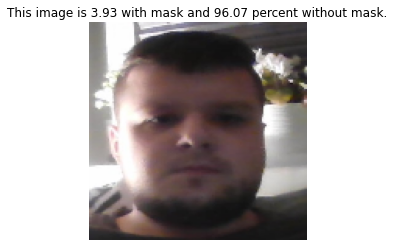

In [14]:
img = keras.preprocessing.image.load_img(
    "test_images/me_without_mask.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

plt.imshow(img)
plt.title("This image is %.2f with mask and %.2f percent without mask." % (100 * (1 - score), 100 * score))
plt.axis("off")


(-0.5, 139.5, 139.5, -0.5)

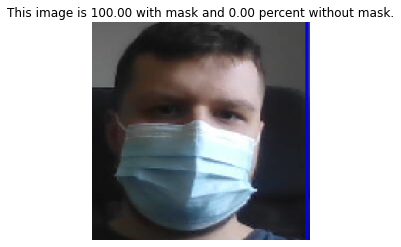

In [ ]:
img = keras.preprocessing.image.load_img(
    "test_images/test.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

plt.imshow(img)
plt.title("This image is %.2f with mask and %.2f percent without mask." % (100 * (1 - score), 100 * score))
plt.axis("off")

(-0.5, 139.5, 139.5, -0.5)

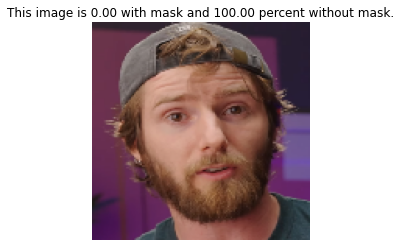

In [ ]:
img = keras.preprocessing.image.load_img(
    "test_images/face_without_mask.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

plt.imshow(img)
plt.title("This image is %.2f with mask and %.2f percent without mask." % (100 * (1 - score), 100 * score))
plt.axis("off")

(-0.5, 139.5, 139.5, -0.5)

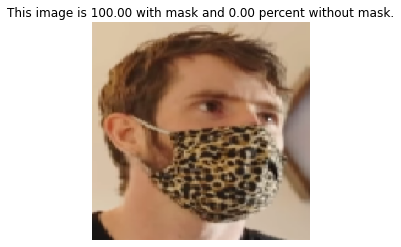

In [ ]:
img = keras.preprocessing.image.load_img(
    "test_images/face_with_mask.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

plt.imshow(img)
plt.title("This image is %.2f with mask and %.2f percent without mask." % (100 * (1 - score), 100 * score))
plt.axis("off")

In [15]:
model.save('saved_model')

INFO:tensorflow:Assets written to: saved_model\assets


C:\Users\olsen\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
